In [1]:
%matplotlib inline
import time
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
import glob
import skimage
from skimage.feature import hog
from scipy.ndimage.measurements import label
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
print('The skimage version is {}.'.format(skimage.__version__))

The skimage version is 0.13.0.


In [2]:
sample_image = mpimg.imread('./test_images/test4.png')

In [3]:
sample_image.shape

(720, 1280, 4)

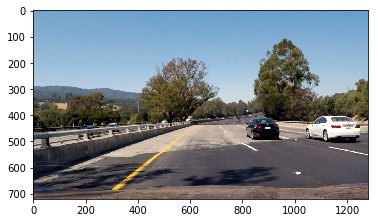

In [4]:
plt.imshow(sample_image)

In [5]:
cars = glob.glob('./data/vehicles/KITTI_extracted/*.png')
notcars = glob.glob('./data/non-vehicles/Extras/*.png')

In [6]:
print("cars images : " + str(len(cars)))
print("not cars image: " + str(len(notcars)))

cars images : 5966
not cars image: 5068


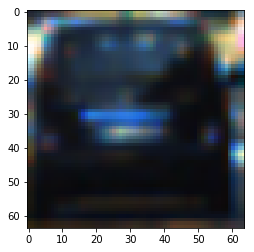

In [7]:
random_car_image = mpimg.imread(cars[np.random.randint(0, len(cars)-1)])
plt.imshow(random_car_image)

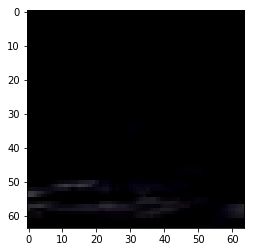

In [8]:
random_notcar_image = mpimg.imread(notcars[np.random.randint(0, len(notcars)-1)])
plt.imshow(random_notcar_image)

In [9]:
def convert_color(img, color_space='RGB'):
    if color_space != 'RGB':
        if color_space == 'HSV':
            converted_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            converted_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            converted_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            converted_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            converted_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: converted_image = np.copy(img)
    return converted_image

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def scale_features(features):
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    return scaled_X 

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

# pipline to extract features
# 1 convert_color
# 2 spactial_features = bin_spatial
# 3 color_hist_features = color_hist
# 4 concatenate featurse
# 5 scale features
def single_img_features(img, color_space='RGB', 
                        spatial_feat=True, spatial_size=(32, 32),
                        hist_feat=True, hist_bins=32, 
                        hog_feat=True, orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        scale_feat=True):
    
    # 1 - Define an empty list for computed features
    img_features = []

    # 2 - Apply color conversion
    feature_image = convert_color(img, color_space)
    
    # 3 - Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Append bin spatial features to list
        # print("spatial_features shape" + str(spatial_features.shape))
        img_features.append(spatial_features)
        
        
    # 4 - Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        # Append histogram features to list
        # print("hist_features shpae" + str(hist_features.shape))
        img_features.append(hist_features)
        
    # 5 - Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append HOG features to list
        # print("hog_features shape : " + str(hog_features.shape))
        img_features.append(hog_features)
        
    # 6 - Concatenate features 
    img_features = np.concatenate(img_features)
    
    # 7 - Scale features
    if scale_feat == True:
        img_features = scale_features(img_features)

    # 8 - Return array of features
    return img_features

# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        t = time.time()
        #print("window : " + str(window))
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        # features = single_img_features(test_img, color_space=color_space, 
        #                   spatial_size=spatial_size, hist_bins=hist_bins, 
        #                   orient=orient, pix_per_cell=pix_per_cell, 
        #                   cell_per_block=cell_per_block, 
        #                   hog_channel=hog_channel, spatial_feat=spatial_feat, 
        #                   hist_feat=hist_feat, hog_feat=hog_feat)
        features = single_img_features(test_img, color_space=color_space, 
                                   spatial_feat=spatial_feat, spatial_size=spatial_size,
                                   hist_feat=hist_feat, hist_bins=hist_bins, 
                                   hog_feat=hog_feat, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                                   scale_feat=False)
        t2 = time.time()
        #print("features time :" + str(round(t2-t,2)) + "features shape : " + str(features.shape))
        #5) Scale extracted features to be fed to classifier
        t = time.time()
        # X_scaler = scaler.fit(features.reshape(1,-1))
        # Apply the scaler to X
        test_features = scaler.transform(features.reshape(1,-1))
        t2 = time.time()
        #print("scaler time : " + str(round(t2-t,2)) + "test_feature shape : " + str(test_features.shape))
        # test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        t = time.time()
        prediction = clf.predict(test_features)
        t2 = time.time()
        #print("Prdiction time :" + str(round(t2-t)) + " prdiction : " + str(prediction))
        #7) If positive (prediction == 1) then save the window
        if prediction[0] == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img


In [10]:
# defaults for feature extraction
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb

spatial_feature = False
spatial_size = (32, 32)

hist_feature = True
hist_bins = 32

hog_feature = True
orient = 32
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"


# test festure extraction
sample_car_image = mpimg.imread(cars[0])
feature_image = convert_color(sample_car_image, color_space)
print("feature_image shpae" + str(feature_image.shape))

spatial_features = bin_spatial(feature_image, size=spatial_size)
print("spatial_features shape" + str(spatial_features.shape))

hist_features = color_hist(feature_image, nbins=hist_bins)
print("hist_features shpae" + str(hist_features.shape))

if hog_channel == 'ALL':
    hog_features = []
    for channel in range(feature_image.shape[2]):
        hog_features.append(get_hog_features(feature_image[:,:,channel], 
                            orient, pix_per_cell, cell_per_block, 
                            vis=False, feature_vec=True))
    hog_features = np.ravel(hog_features)
else:
    hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                                    pix_per_cell, cell_per_block, vis=False, feature_vec=True)
print("hog_features shape : " + str(hog_features.shape))

img_features = []
img_features.append(spatial_features)
img_features.append(hist_features)
img_features.append(hog_features)
print("img_features len : " + str(len(img_features)))
img_features = np.concatenate(img_features)
print("img_features shape : " + str(img_features.shape))

feature_image shpae(64, 64, 3)
spatial_features shape(3072,)
hist_features shpae(96,)
hog_features shape : (18816,)
img_features len : 3
img_features shape : (21984,)


/Users/mh/dev/tool/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [11]:
t= time.time()

# build car features
car_features = []
for car in cars:
    image = mpimg.imread(car)
    features = single_img_features(image, color_space=color_space, 
                                   spatial_feat=spatial_feature, spatial_size=spatial_size,
                                   hist_feat=hist_feature, hist_bins=hist_bins, 
                                   hog_feat=hog_feature, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                                   scale_feat=False)
    car_features.append(features)
    
# build not car features
notcar_features = []
for notcar in notcars:
    image = mpimg.imread(notcar)
    features = single_img_features(image, color_space=color_space, 
                                   spatial_feat=spatial_feature, spatial_size=spatial_size,
                                   hist_feat=hist_feature, hist_bins=hist_bins, 
                                   hog_feat=hog_feature, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                                   scale_feat=False)
    notcar_features.append(features)

t1= time.time()
print("Time in seconds to extract car and not car features : " + str(round(t1-t, 2)))

/Users/mh/dev/tool/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Time in seconds to extract car and not car features : 111.16


In [12]:
# Create an array stack of feature vectors
print("car_features len : " + str(len(car_features)))
print("notcar_features len : " + str(len(notcar_features)))
print("car_features shape : " + str(car_features[0].shape))
print("notcar_features shape : " + str(notcar_features[0].shape))

t= time.time()
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)
t1= time.time()
print("Time in seconds to scale features of combined car and not car features : " + str(round(t1-t, 2)))

car_features len : 5966
notcar_features len : 5068
car_features shape : (18912,)
notcar_features shape : (18912,)
Time in seconds to scale features of combined car and not car features : 21.58


In [13]:
# build labels vector based on car and notcar features list
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# build feature vecor

In [14]:
t= time.time()

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

t1= time.time()
print("Time in seconds to splite train_test sets : " + str(round(t1-t, 2)))

Time in seconds to splite train_test sets : 0.88


In [15]:
# find optimized parameters for SVM clssifier
t= time.time()
# parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
# svr = svm.SVC()
# clf = grid_search.GridSearchCV(svr, parameters)
#clf.fit(X_train, y_train)

svc = LinearSVC()
svc.fit(X_train, y_train)
print('Test Accuracy of SVC = ', svc.score(X_test, y_test))

# print('My SVC predicts: ', svc.predict(X_test[0:10].reshape(1, -1)))
print('My SVC predicts: ', svc.predict(X_test[0:10]))

print('For labels: ', y_test[0:10])

t1 = time.time()
print('Training time:' , round(t1-t, 2))

Test Accuracy of SVC =  0.999093792478
My SVC predicts:  [ 1.  0.  1.  1.  0.  1.  0.  1.  0.  1.]
For labels:  [ 1.  0.  1.  1.  0.  1.  0.  1.  0.  1.]
Training time: 138.51


In [16]:
window_list = slide_window(sample_image, x_start_stop=[None, None], y_start_stop=[400, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5))

In [17]:
#window_list

/Users/mh/dev/tool/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


on_windows num :  0


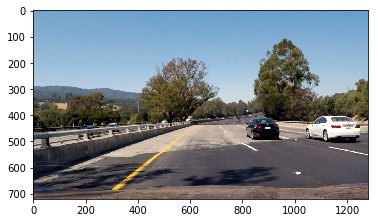

In [18]:
# test model
on_windows = search_windows(sample_image, window_list, svc, X_scaler, color_space=color_space, 
                    spatial_size=spatial_size, hist_bins=hist_bins, 
                    hist_range=(0, 256), orient=orient, 
                    pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                    hog_channel=hog_channel, spatial_feat=spatial_feature, 
                    hist_feat=hist_feature, hog_feat=hog_feature)

boxes_image = draw_boxes(sample_image, on_windows)
print("on_windows num : ", len(on_windows))
plt.imshow(boxes_image)

In [ ]:
out_img = find_cars(sample_image, 400, 656, 1.5, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
plt.imshow(out_img)

In [109]:
sri_features = single_img_features(sample_re_image, color_space=color_space, 
                                   spatial_feat=spatial_feature, spatial_size=spatial_size,
                                   hist_feat=hist_feature, hist_bins=hist_bins, 
                                   hog_feat=hog_feature, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                                   scale_feat=False)

/Users/mh/dev/tool/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [122]:
print("sri_features[0] : " , sri_features.reshape(1,-1))
X_scaler = StandardScaler().fit(sri_features.reshape(1,-1))
# Apply the scaler to X
scaled_X = X_scaler.transform(sri_features.reshape(1,-1))
print("scaled_X[0] :" , scaled_X[0])

sri_features[0] :  [[  1.90000000e+01   2.10000000e+01   2.20000000e+01 ...,   6.66212762e-03
    4.27371140e-03   5.35375670e-03]]
scaled_X[0] : [ 0.  0.  0. ...,  0.  0.  0.]


In [126]:
scaled_X = X_scaler.transform(sri_features.reshape(1,-1))
scaled_X

array([[-1.25182209, -1.23789903, -1.23524208, ..., -0.14827292,
        -0.42171096, -0.35039973]])

In [127]:
svc.predict(scaled_X)

array([ 1.])

In [116]:
sri_features.shape

(13752,)

In [117]:
scaled_X.shape

(1, 13752)

In [124]:
[scaled_X > 0]

[array([[False, False, False, ..., False, False, False]], dtype=bool)]

In [56]:
f = single_img_features(sample_re_image, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feature, 
                            hist_feat=hist_feature, hog_feat=hog_feature)

/Users/mh/dev/tool/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [57]:
f.shape

(11034, 13752)

In [58]:
sf = single_img_features(sample_image, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feature, 
                            hist_feat=hist_feature, hog_feat=hog_feature)

/Users/mh/dev/tool/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [59]:
sf.shape

(11034, 13752)

In [60]:
sx = single_img_features(sample_image, color_space=color_space, 
                                   spatial_feat=spatial_feature, spatial_size=spatial_size,
                                   hist_feat=hist_feature, hist_bins=hist_bins, 
                                   hog_feat=hog_feature, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                                   scale_feat=False)

/Users/mh/dev/tool/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


prediction :  [ 0.]


/Users/mh/dev/tool/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


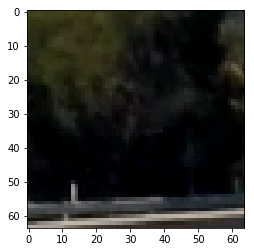

In [325]:
random_notcar_image = mpimg.imread(notcars[np.random.randint(0, len(notcars)-1)])
rnc_feature = single_img_features(random_notcar_image, color_space=color_space, 
                                   spatial_feat=spatial_feature, spatial_size=spatial_size,
                                   hist_feat=hist_feature, hist_bins=hist_bins, 
                                   hog_feat=hog_feature, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                                   scale_feat=False)
rnc_feature_scaled = X_scaler.transform(rnc_feature.reshape(1,-1))
print("prediction : " , svc.predict(rnc_feature_scaled))
plt.imshow(random_notcar_image)

prediction :  [ 0.]


/Users/mh/dev/tool/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


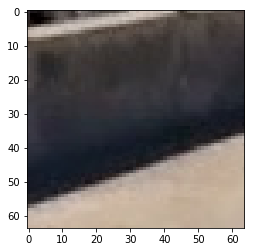

In [517]:
window = window_list[np.random.randint(0,len(window_list)-1)]
img = sample_image
random_notcar_image =  cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
rnc_feature = single_img_features(random_notcar_image, color_space=color_space, 
                                   spatial_feat=spatial_feature, spatial_size=spatial_size,
                                   hist_feat=hist_feature, hist_bins=hist_bins, 
                                   hog_feat=hog_feature, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                                   scale_feat=False)
rnc_feature_scaled = X_scaler.transform(rnc_feature.reshape(1,-1))
print("prediction : " , svc.predict(rnc_feature_scaled))
plt.imshow(random_notcar_image)

prediction :  [ 0.]


/Users/mh/dev/tool/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


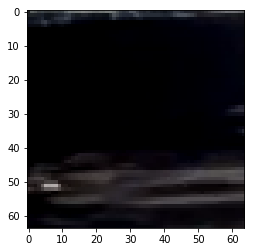

In [328]:
rn_feature = single_img_features(random_notcar_image, color_space=color_space, 
                                   spatial_feat=spatial_feature, spatial_size=spatial_size,
                                   hist_feat=hist_feature, hist_bins=hist_bins, 
                                   hog_feat=hog_feature, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                                   scale_feat=False)
rnc_feature_scaled = X_scaler.transform(rnc_feature.reshape(1,-1))
print("prediction : " , svc.predict(rnc_feature_scaled))
plt.imshow(random_notcar_image)


In [329]:
spatial_size

(32, 32)

In [206]:
hist_feature

True

In [66]:
hist_bins

32

In [67]:
hog_feature

True

In [68]:
orient

18

In [69]:
pix_per_cell

8

In [70]:
cell_per_block

2

In [71]:
hog_channel

'ALL'

In [72]:
sw = single_img_features(sample_re_image, color_space=color_space, 
                                   spatial_feat=spatial_feature, spatial_size=spatial_size,
                                   hist_feat=hist_feature, hist_bins=hist_bins, 
                                   hog_feat=hog_feature, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                                   scale_feat=False)

/Users/mh/dev/tool/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [73]:
sw.shape

(13752,)

In [74]:
sample_re_image.shape

(64, 64, 3)

In [79]:
sw.reshape(1,-1).shape

(1, 13752)

In [86]:
len(on_windows)

351

In [87]:
len(window_list)

351

In [94]:
prediction = [1.]

In [95]:
prediction == 2

False

In [96]:
prediction == 1

False

In [97]:
prediction[0] == 1

True

In [104]:
svc

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

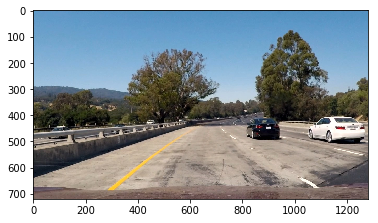

In [105]:
plt.imshow(sample_image)